   Unnamed: 0   obecA   obecB  pocet  okresA  okresB obecA_nazov  \
0           1  507300  507300     18  SK0318  SK0318   Ivachnová   
1           2  507300  507407      1  SK0318  SK0318   Ivachnová   
2           3  507300  510262     10  SK0318  SK0315   Ivachnová   
3           4  507300  510301      6  SK0318  SK0318   Ivachnová   
4           5  507300  510386      1  SK0318  SK0315   Ivachnová   

         obecB_nazov kod_start      start_x       start_y kod_dest  \
0          Ivachnová    507300  -395493.798  -1190259.070   507300   
1              Turík    507300  -395493.798  -1190259.070   507407   
2  Liptovský Mikuláš    507300  -395493.798  -1190259.070   510262   
3           Bešeňová    507300  -395493.798  -1190259.070   510301   
4  Demänovská Dolina    507300  -395493.798  -1190259.070   510386   

         end_x         end_y                         geometry  
0  -395493.798  -1190259.070  POINT (-395493.798 -1190259.07)  
1  -397590.562  -1188467.760  POINT (-3954

<Figure size 827x1169 with 0 Axes>

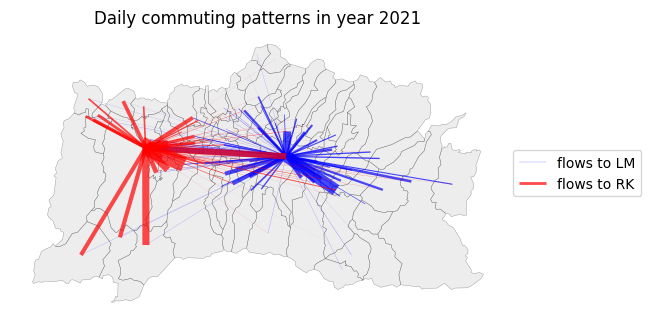

In [24]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib .patches import Patch, Rectangle
from shapely.geometry import Point
from shapely.geometry import LineString

f = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")

b = gpd.read_file(r"../data/liptov_obce.csv", encoding = "windows-1250")

f["obecA"] = f["obecA"].astype(str)
f["obecB"] = f["obecB"].astype(str)
b["kod"] = b["kod"].astype(str)
f = f.merge(
    b[["kod", "x", "y"]],
    left_on = "obecA",
    right_on = "kod",
    how = "left"
).rename(columns={"x": "start_x", "y": "start_y", "kod": "kod_start"})

f = f.merge(
    b[["kod", "x", "y"]],
    left_on = "obecB",
    right_on = "kod",
    how = "left"
).rename(columns={"x": "end_x", "y": "end_y", "kod": "kod_dest"})
commuting_gdf = gpd.GeoDataFrame(
    f,
    geometry=[Point(xy) for xy in zip(f["start_x"], f["start_y"])],
    crs="EPSG:5514"
)
print(commuting_gdf.head())

background = gpd.read_file(r"../data/geo/liptov.shp")
flows_selected = f[f["kod_dest"].isin(["510262", "510998"])].copy()


flows_selected["geometry"] = flows_selected.apply(
    lambda row: LineString([(row["start_x"], row["start_y"]), (row["end_x"], row["end_y"])]),
    axis = 1
)

line_gdf = gpd.GeoDataFrame(flows_selected, geometry = "geometry", crs="EPSG:5514")

flows_510262 = line_gdf[line_gdf["kod_dest"] == "510262"]
flows_510998 = line_gdf[line_gdf["kod_dest"] == "510998"]

plt.figure(figsize = (8.27, 11.69))


ax = background.plot(
    alpha = 0.4,
    edgecolor = "black",
    color = "lightgray",
    linewidth = 0.3
)

flows_510262.plot(
    ax = ax,
    linewidth = flows_510262["pocet"] / flows_510262["pocet"].max()*100,
    alpha = 0.7,
    color = "blue",
    label = "flows to LM"
)

flows_510998.plot(
    ax = ax,
    linewidth = flows_510998["pocet"] / flows_510998["pocet"].max()*100,
    alpha = 0.7,
    color = "red",
    label = "flows to RK"
)

plt.legend(
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = True
)

plt.title("Daily commuting patterns in year 2021")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis(False)

plt.grid(False)

plt.savefig("../result_maps/test_LM_RK_1.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

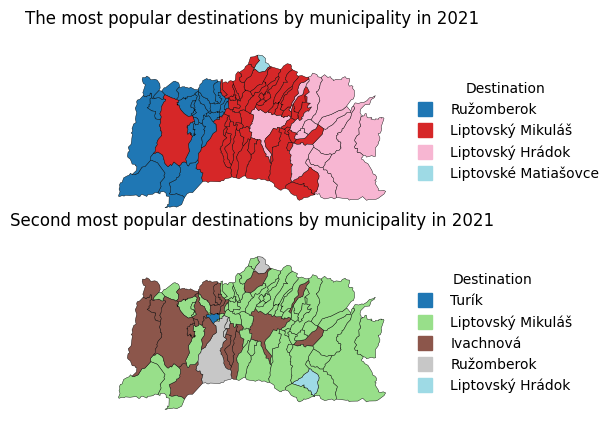

    obecA   obecB        obecB_nazov  pocet
0  507300  510998         Ružomberok     93
1  507393  510262  Liptovský Mikuláš     41
2  507407  510998         Ružomberok     27
3  510262  510726   Liptovský Hrádok    403
4  510271  510262  Liptovský Mikuláš     95
    obecA   obecB        obecB_nazov  pocet
0  507300  507407              Turík      1
1  507393  510262  Liptovský Mikuláš     41
2  507407  510262  Liptovský Mikuláš      2
3  510262  507300          Ivachnová      3
4  510271  510262  Liptovský Mikuláš     95


In [25]:
commuting = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")

map = gpd.read_file(r"../data/geo/liptov.shp")

commuting[["obecA", "obecB"]] = commuting[["obecA", "obecB"]].astype(str)
map["IDN4"] = map["IDN4"].astype(str)

most_popular = (
    commuting[commuting["obecA"] != commuting["obecB"]]
    .groupby("obecA", group_keys = False)[["obecA", "obecB", "obecB_nazov", "pocet"]]
    .apply(lambda x: x.loc[x["pocet"].idxmax()])
    .reset_index(drop = True)
)

result = map.merge(
    most_popular[["obecA", "obecB", "obecB_nazov"]],
    left_on = "IDN4",
    right_on = "obecA",
    how = "left"
).rename(columns={"IDN4": "kod_start"})
unique_dest = result["obecB_nazov"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_dest)))
color_dict = dict(zip(unique_dest, colors))

second_popular = (
    commuting[commuting["obecA"] != commuting["obecB"]]
    .groupby("obecA", group_keys = False)[["obecA", "obecB", "obecB_nazov", "pocet"]]
    .apply(lambda x: x.nlargest(2, "pocet").iloc[-1] if len(x) > 1 and x.nlargest(2, "pocet")["pocet"].iloc[1] >= x.nlargest(2, "pocet")["pocet"].iloc[0] * 0.75 else x.iloc[0])
    .reset_index(drop=True)
)
result2 = map.merge(
    second_popular[["obecA", "obecB", "obecB_nazov"]],
    left_on = "IDN4",
    right_on = "obecA",
    how = "left"
).rename(columns = {"IDN4": "kod_start"})
second_dest = result2["obecB_nazov"].unique()
colors2 = plt.cm.tab20(np.linspace(0, 1, len(second_dest)))
color_dict2 = dict(zip(second_dest, colors2))

plt.subplot(2, 1, 1)
result.plot(
    ax = plt.gca(),
    color = [color_dict.get(d, "lightgray") for d in result["obecB_nazov"]],
    edgecolor = "black",
    linewidth = 0.3
)

handles = [
    plt.Line2D(
        [0], [0],
        marker = "s",
        markersize = 10,
        linestyle = "None",
        color = color,
        # edgecolor = "black",
        label = dest
        )
        for dest, color in color_dict.items()
]

plt.legend(
    handles = handles,
    title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)

plt.title("The most popular destinations by municipality in 2021")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.axis(False)

plt.subplot(2, 1, 2)
result2.plot(
    ax = plt.gca(),
    color = [color_dict2.get(d, "lightgray") for d in result2["obecB_nazov"]],
    edgecolor = "black",
    linewidth = 0.3
)
handles2 = [
    plt.Line2D(
        [0], [0],
        marker = "s",
        markersize = 10,
        linestyle = "None",
        color = color,
        # edgecolor = "black",
        label = dest
        )
        for dest, color in color_dict2.items()
]
plt.legend(
    handles = handles2,
    title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)
plt.title("Second most popular destinations by municipality in 2021")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.axis(False)
# plt.suptitle("Daily commuting patterns in Liptov region")
plt.savefig("../result_maps/test_LM_RK_2.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()
print(most_popular.head())
print(second_popular.head())